# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [0]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import os
import numpy as np
import pandas as pd
from six.moves import urllib

np.random.seed(42)

#fetch and load data
DATA_PATH = os.path.join(".","assignment3")
os.makedirs(DATA_PATH, exist_ok=True)
DATA_URL = "https://raw.githubusercontent.com/MintForever/CS4774/master/CaliforniaHousing.csv"

csv_path = os.path.join(DATA_PATH, "californiaHousing.csv")
urllib.request.urlretrieve(DATA_URL, csv_path)
data= pd.read_csv(csv_path)


In [3]:
#data summary
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8183844550>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

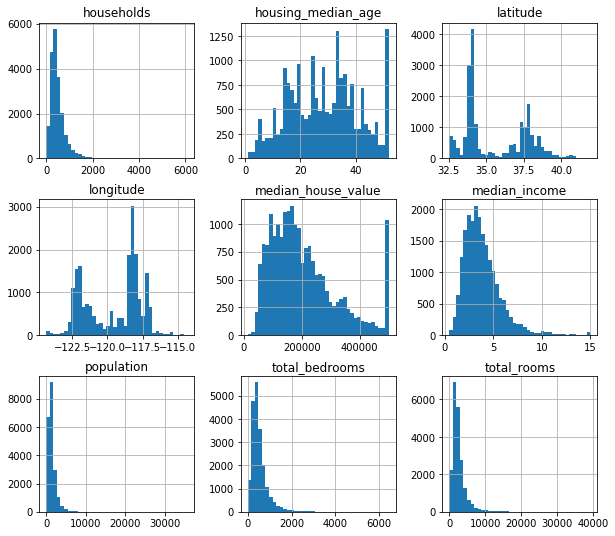

In [4]:
#data visualization
import matplotlib.pyplot as plt
plt.figure()
data.hist(bins=40, figsize=(10,9))


In [5]:
from pandas.plotting import scatter_matrix

corr_matrix = data.corr()["median_house_value"].sort_values(ascending=False)
corr_matrix

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8182c977f0>,
      dtype=object)

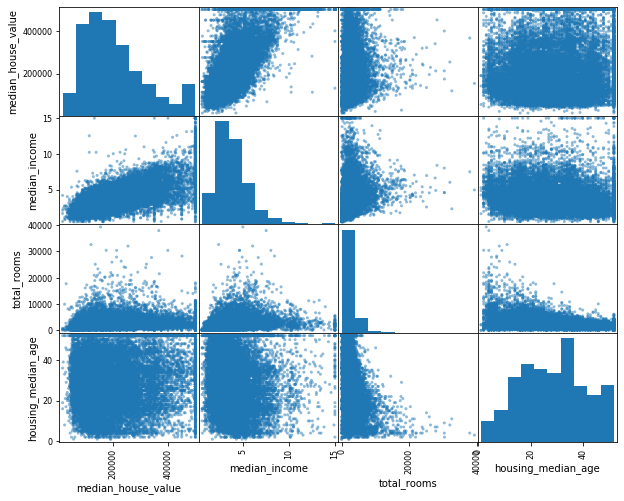

In [6]:

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(data[attributes], figsize=(10, 8))

In [7]:
#data cleaning
from sklearn.compose import ColumnTransformer

num_attr = list(data.columns)
num_attr.remove("ocean_proximity")
cat_attr = ["ocean_proximity"]

num_pipeline= Pipeline([
                        ("imputer",SimpleImputer(strategy="median")),
                        ("std_scaler", StandardScaler())
])

full_pipeline= ColumnTransformer([
                         ("num", num_pipeline, num_attr),
                         ("cat", OneHotEncoder(), cat_attr)
])

final_data = full_pipeline.fit_transform(data)
print(data.shape)
print(final_data.shape)

(20640, 10)
(20640, 14)


- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [0]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).


def k_means(k,data = final_data, metric=" manhattan"):
  np.random.seed(42)
  centroids = data[np.random.randint(0, data.shape[0]-1, k)]
  dist_mat = calcDist(data, centroids, metric)
  # dist_mat_np = np.asarray(dist_mat)

  min_index= dist_mat.argmin(axis=1)
  # curr_dist_mat_np = np.empty((data.shape[0],k))
  curr_dist_mat = np.empty((data.shape[0],k))
  index_for_each_cluster=[]
  count = 0


  
  while (not (np.array_equal(dist_mat, curr_dist_mat))):
    if count == 299:
      count = 0
      print("again")
      centroids = data[np.random.randint(0, data.shape[0]-1, k)]
      dist_mat = calcDist(data, centroids, metric)
      min_index= dist_mat.argmin(axis=1)

    sse = 0
    count+=1
    dist_mat = curr_dist_mat
    min_index= dist_mat.argmin(axis=1)
    # print("min_index", min_index)
    index_for_each_cluster=[]
    std = np.empty((k, data.shape[1]))

    for i in range(k):
      indexes= [j for j, value in enumerate(min_index) if value == i]
      index_for_each_cluster.append(indexes)
      centroids[i] = np.average(data[indexes],axis=0)
      std[i] = np.std(data[indexes], axis=0)
      sse += (calcDist(data[indexes], centroids[np.newaxis,i], metric="euclidean")**2).sum()
    curr_dist_mat = calcDist(data, centroids, metric)
    # curr_dist_mat_np = np.asarray(curr_dist_mat)
  # print(count)

  # std = np.empty((k, data.shape[0]))
  # for i in range (k):
  #   std[i] = np.std(data[index_for_each_cluster[i]], axis=0)

  return centroids, min_index, std, sse




def calcDist(x,y,metric):
  m = x.shape[0]
  dist = np.empty((x.shape[0],y.shape[0]))
  p = 1
  if metric == "euclidean":
    p = 2
  if metric == "sup":
    for i in range(m):
      dist[i] = (np.abs(x[i]-y).max(axis=1))
  else:
    for i in range(m):
      dist[i] = (((np.abs(x[i]-y)**p).sum(axis=1))**(1/p))
  return dist


- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


k= 2
SSE: 162062.262445396
feature 1 :
longitude mean: -1.024264647391347
longitude standard deviation: 0.5023394537978267
latitude mean: 1.0537540669555674
latitude standard deviation: 0.48634223558878004
housing_median_age mean: 0.03687227795326106
housing_median_age standard deviation: 1.046121922782877
total_rooms mean: -0.11638681022611996
total_rooms standard deviation: 0.6938625308254951
total_bedrooms mean: -0.1499452239464657
total_bedrooms standard deviation: 0.7076167957253915
population mean: -0.19030376221127399
population standard deviation: 0.6881320546090975
households mean: -0.15154007529252056
households standard deviation: 0.7337193867847814
median_income mean: -0.07014702380477766
median_income standard deviation: 0.9754573334599249
median_house_value mean: -0.13137155585882052
median_house_value standard deviation: 1.0211135433848364
ocean_proximity mean: 0.17397644419517666
ocean_proximity standard deviation: 0.37908922572447695
ocean proximity1 mean: 0.4749298934

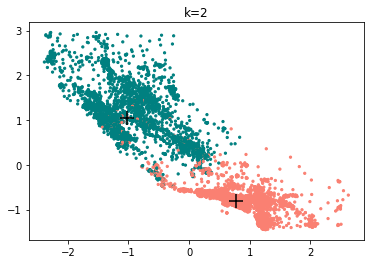

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2339: RuntimeWarning:

invalid value encountered in equal



k= 3
SSE: 122226.85564020059
feature 1 :
longitude mean: -1.034622627245096
longitude standard deviation: 0.4936079244637241
latitude mean: 1.0686390130880672
latitude standard deviation: 0.47371399342567616
housing_median_age mean: 0.0746487606206636
housing_median_age standard deviation: 1.042021762521996
total_rooms mean: -0.20757493692052084
total_rooms standard deviation: 0.5200337204546583
total_bedrooms mean: -0.24296975990425973
total_bedrooms standard deviation: 0.5347261621290972
population mean: -0.2789119855835748
population standard deviation: 0.5302523522489174
households mean: -0.24901651273262515
households standard deviation: 0.5519999075319377
median_income mean: -0.07433639650195528
median_income standard deviation: 0.979728043623096
median_house_value mean: -0.13162500918171463
median_house_value standard deviation: 1.024566076439934
ocean_proximity mean: 0.17202630005977287
ocean_proximity standard deviation: 0.37740330171782277
ocean proximity1 mean: 0.47352062163

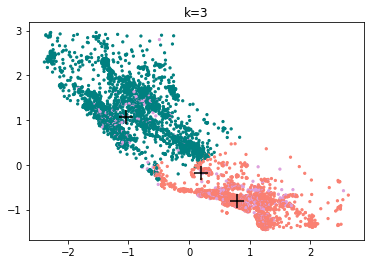

k= 4
SSE: 107067.74885218637
feature 1 :
longitude mean: 0.8068615820817571
longitude standard deviation: 0.3819779264333625
latitude mean: -0.8112939184662049
latitude standard deviation: 0.2841336127800382
housing_median_age mean: 0.09097234248656161
housing_median_age standard deviation: 0.9049158838568814
total_rooms mean: -0.25025583965127335
total_rooms standard deviation: 0.4856065363354268
total_bedrooms mean: -0.17356420347412954
total_bedrooms standard deviation: 0.5516736775836378
population mean: -0.09283280264035586
population standard deviation: 0.5984805793775612
households mean: -0.17134141527324168
households standard deviation: 0.5494990687795657
median_income mean: -0.2969569915542049
median_income standard deviation: 0.6250246278235524
median_house_value mean: -0.28102705506951675
median_house_value standard deviation: 0.5962244171400788
ocean_proximity mean: 0.624259681093394
ocean_proximity standard deviation: 0.48431346425073657
ocean proximity1 mean: 0.221640091

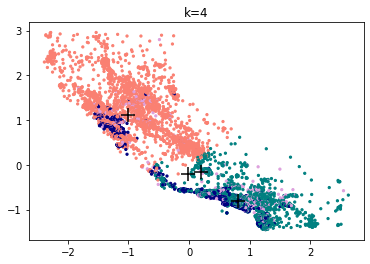

k= 5
SSE: 94857.05423576239
feature 1 :
longitude mean: -0.04558080499610407
longitude standard deviation: 0.9700736658551633
latitude mean: -0.1804953125131882
latitude standard deviation: 0.8403756358954512
housing_median_age mean: 0.14195476958794023
housing_median_age standard deviation: 1.0219571229936857
total_rooms mean: -0.02577559878797473
total_rooms standard deviation: 0.5657907907046384
total_bedrooms mean: -0.2795328138173497
total_bedrooms standard deviation: 0.4807351028418676
population mean: -0.3282458953382329
population standard deviation: 0.4620203963036704
households mean: -0.25924965493484425
households standard deviation: 0.49420429049915576
median_income mean: 1.5815511191541838
median_income standard deviation: 1.2032916329899261
median_house_value mean: 1.7520420075303609
median_house_value standard deviation: 0.709516205093376
ocean_proximity mean: 0.5967121371108779
ocean_proximity standard deviation: 0.4905576036873212
ocean proximity1 mean: 0.0626093039524

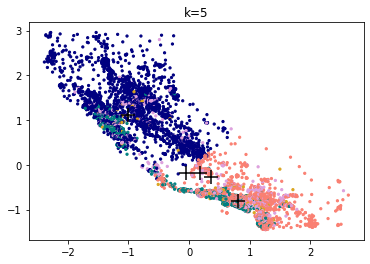

k= 6
SSE: 87383.14038822992
feature 1 :
longitude mean: 0.3676426015140386
longitude standard deviation: 0.956604884524557
latitude mean: -0.2795279428370658
latitude standard deviation: 0.8866293256330126
housing_median_age mean: -1.3276514873355423
housing_median_age standard deviation: 0.6169694008424467
total_rooms mean: 5.356177503541711
total_rooms standard deviation: 2.406976413335365
total_bedrooms mean: 5.191002407488631
total_bedrooms standard deviation: 2.01761490535205
population mean: 5.001424003314223
population standard deviation: 2.71677269917564
households mean: 5.155638665245238
households standard deviation: 2.0213235410373755
median_income mean: 0.3105851587974932
median_income standard deviation: 0.8332354102135956
median_house_value mean: 0.07580941251427747
median_house_value standard deviation: 0.8576117923579065
ocean_proximity mean: 0.40145985401459855
ocean_proximity standard deviation: 0.49019367563155525
ocean proximity1 mean: 0.44525547445255476
ocean prox

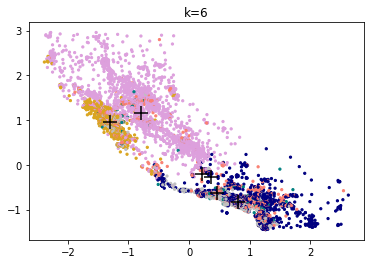

k= 7
SSE: 82334.81809027249
feature 1 :
longitude mean: 0.7050102139843947
longitude standard deviation: 0.3002527990686753
latitude mean: -0.8254973510174817
latitude standard deviation: 0.1983653831210506
housing_median_age mean: 0.00806169331616499
housing_median_age standard deviation: 0.9877508598612031
total_rooms mean: -0.028040516496242097
total_rooms standard deviation: 0.5508743193110945
total_bedrooms mean: -0.24723750131998684
total_bedrooms standard deviation: 0.4704287539211612
population mean: -0.29242023977729165
population standard deviation: 0.4466236015282381
households mean: -0.22903012177855062
households standard deviation: 0.48032317661416407
median_income mean: 1.2864970609246853
median_income standard deviation: 1.1401535428580034
median_house_value mean: 1.4332739478015084
median_house_value standard deviation: 0.8184921072476534
ocean_proximity mean: 0.7681102362204725
ocean_proximity standard deviation: 0.4220389807041503
ocean proximity1 mean: 0.06535433070

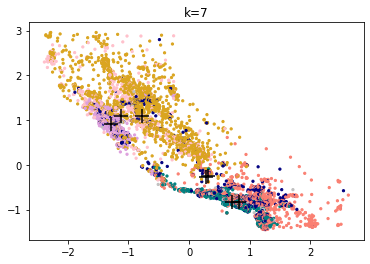

k= 8
SSE: 76465.24765660927
feature 1 :
longitude mean: 0.8517884403301665
longitude standard deviation: 0.41276137128981594
latitude mean: -0.8329159632569372
latitude standard deviation: 0.3046811203622674
housing_median_age mean: -0.5353069013163564
housing_median_age standard deviation: 0.7483410486542482
total_rooms mean: 0.27521560155952435
total_rooms standard deviation: 0.4522669311001226
total_bedrooms mean: 0.42272284916017
total_bedrooms standard deviation: 0.48096390073117323
population mean: 0.46252218675395307
population standard deviation: 0.5939406357666356
households mean: 0.4214779522712005
households standard deviation: 0.46504042794286926
median_income mean: -0.23067557733068766
median_income standard deviation: 0.6201138401962581
median_house_value mean: -0.2281574821695733
median_house_value standard deviation: 0.5975604574469768
ocean_proximity mean: 0.5539546290619252
ocean_proximity standard deviation: 0.497080373785552
ocean proximity1 mean: 0.2645616186388718

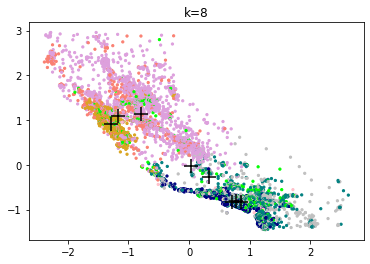

k= 9
SSE: 72457.75928035704
feature 1 :
longitude mean: -1.2721709929261713
longitude standard deviation: 0.17967547859868863
latitude mean: 0.9144986342052659
latitude standard deviation: 0.19563697876330152
housing_median_age mean: 0.18062593677214367
housing_median_age standard deviation: 0.9898334290176524
total_rooms mean: -0.12643055903492256
total_rooms standard deviation: 0.5267207748994511
total_bedrooms mean: -0.35190844509272684
total_bedrooms standard deviation: 0.4587171392720836
population mean: -0.38631151003345854
population standard deviation: 0.43542661617220096
households mean: -0.3246399260404949
households standard deviation: 0.481538937947161
median_income mean: 1.3858538178196989
median_income standard deviation: 1.1273824811201993
median_house_value mean: 1.5001350618384384
median_house_value standard deviation: 0.791818697824589
ocean_proximity mean: 0.3303072625698324
ocean_proximity standard deviation: 0.47032369158214254
ocean proximity1 mean: 0.073324022346

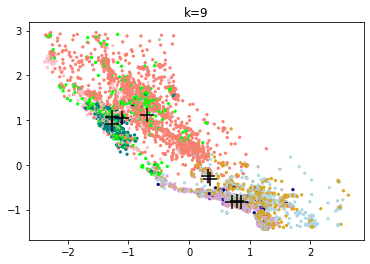

k= 10
SSE: 69454.38323315812
feature 1 :
longitude mean: 0.29507650287653253
longitude standard deviation: 0.9294106065515895
latitude mean: -0.2687692575656458
latitude standard deviation: 0.8521526495795705
housing_median_age mean: -0.9738824526432094
housing_median_age standard deviation: 0.6984307379390193
total_rooms mean: 2.403541456690596
total_rooms standard deviation: 0.9637530781303073
total_bedrooms mean: 2.5244547325184294
total_bedrooms standard deviation: 0.8807957115990498
population mean: 2.297057153557809
population standard deviation: 0.9856310159671386
households mean: 2.51443390467349
households standard deviation: 0.8310873296185531
median_income mean: 0.16933058378741722
median_income standard deviation: 0.8929595784110291
median_house_value mean: 0.12499543036936375
median_house_value standard deviation: 0.9054099959634853
ocean_proximity mean: 0.47750865051903113
ocean_proximity standard deviation: 0.49949388304415365
ocean proximity1 mean: 0.35870818915801617
o

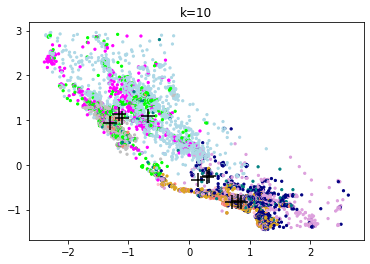

In [149]:
# Your code goes here

color = np.array(['teal', 'salmon', 'plum', 'navy', 'goldenrod', 'silver', 'pink', 'lime', 'lightblue', 'magenta'])
import plotly.graph_objects as go


val = list(data.columns)
val.extend(["ocean proximity1","ocean proximity2","ocean proximity3","ocean proximity4"])

for i in range (2,11):
  centroids, index_for_each_cluster, std, sse = k_means(i, metric="euclidean")
  print("k=", i)
  print("SSE:", sse)
  for k in range(0,i):
    print("feature", k+1, ":")
    for j in range(len(val)):
      print(val[j], "mean:", centroids[k][j])
      print(val[j], "standard deviation:", std[k][j])
    print("\n")
  

  plt.scatter(final_data[:,0],final_data[:,1], s=5,c=color[index_for_each_cluster])
  plt.title("k="+str(i))
  plt.scatter(centroids[:,0],centroids[:,1],marker="+",s=200,c="black")
  plt.show()


As the number of clusters increases, the mean of each cluster of each attribute becomes more stablized, and the standard deviation decreases. Additionally, the clusters begin to resemble shapes of cities in California as the number of clusters increases, yet the clusters cannot perfectly depict the city borders, probably due to noises in the data and the fact that some cities don't have too much differences between each other.

When k is small, the number of clusters is not large enough to separate points based on their characteristics well. When k = 4, the left costal area separates itself from the rest, meaning that the costal area has distinctive features that data points from other areas don't have. 

At k = 10, we can clearly see the silicon valley being clearly separated from the rest, identified by the silver dots on the graph. The boundary of SF is not as clear as that of the silicon valley, but it is still somewhat identifiable by the peach pink dots.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



As the number of clusters increases, the k-means technique begins to show city boundaries and we will be able to identify the silicon valley and SF from the rest. However, we also begin to see some overfitting as the number of clusters increases. For instance, when k = 10, many clusters span a large geographic range, which can be because noises are also taken into account for grouping, and some minor unimportant details are also considered. This suggests that it is very important to choose a right k value. In my case, a suitable k value would be around 8.

I noticed that for many clusters, the median income value is very close to the median house value, suggesting that a lot of people have to use the majority of income for rent payment. This implies that the price for housing is too high. Especially for regions like silicon valley, housing is even more unaffordable. The government can encourage companies to give higher salaries to workers by lowering the tax that companies need to pay. A price ceiling for housing can also be set for certain regions to avoid unreasonable increase in housing price. Incentives can be given to encourage more people to move into less developed areas by offering more job opportunities or better facilities.



# - - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!